# Model Training: SARIMA (Per Product)

Ce notebook entraîne un modèle SARIMA dédié pour chaque produit du dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
import warnings

warnings.filterwarnings('ignore')

os.makedirs('trained_models', exist_ok=True)
print("✅ Bibliothèques importées.")

/home/raph/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✅ Bibliothèques importées.


## Chargement et Préparation des Données
Nous rechargeons les données brutes pour pouvoir séparer par produit et agréger correctement.

In [2]:
file_path = './retail_store_inventory.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Conversion Date
df['Date'] = pd.to_datetime(df['Date'])

print(f"📦 Données chargées: {df.shape}")

📦 Données chargées: (73100, 15)


## Entraînement par Produit
Nous allons boucler sur chaque `Product ID`, agréger les ventes à la semaine (pour lisser et capturer la saisonnalité), et entraîner un modèle SARIMA.

🔍 20 produits trouvés.

🚀 Traitement du produit: P0001...
   ✅ Modèle entraîné. RMSE: 1921.45 | MAE: 1627.13


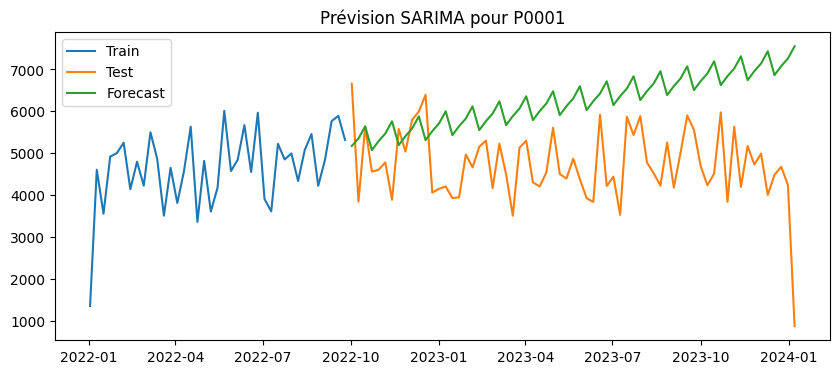


🚀 Traitement du produit: P0002...
   ✅ Modèle entraîné. RMSE: 1362.23 | MAE: 1126.10

🚀 Traitement du produit: P0003...
   ✅ Modèle entraîné. RMSE: 1202.32 | MAE: 936.50

🚀 Traitement du produit: P0004...
   ✅ Modèle entraîné. RMSE: 984.45 | MAE: 755.97

🚀 Traitement du produit: P0005...
   ✅ Modèle entraîné. RMSE: 1399.21 | MAE: 1147.27

🚀 Traitement du produit: P0006...
   ✅ Modèle entraîné. RMSE: 1452.64 | MAE: 1188.10

🚀 Traitement du produit: P0007...
   ✅ Modèle entraîné. RMSE: 801.69 | MAE: 532.46

🚀 Traitement du produit: P0008...
   ✅ Modèle entraîné. RMSE: 1360.29 | MAE: 1115.67

🚀 Traitement du produit: P0009...
   ✅ Modèle entraîné. RMSE: 960.91 | MAE: 659.54

🚀 Traitement du produit: P0010...
   ✅ Modèle entraîné. RMSE: 1520.59 | MAE: 1289.21

🚀 Traitement du produit: P0011...
   ✅ Modèle entraîné. RMSE: 869.11 | MAE: 595.48

🚀 Traitement du produit: P0012...
   ✅ Modèle entraîné. RMSE: 1009.43 | MAE: 730.88

🚀 Traitement du produit: P0013...
   ✅ Modèle entraîné. RMSE: 1

In [3]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

products = df['Product ID'].unique()
results = []

print(f"🔍 {len(products)} produits trouvés.")

for product_id in products:
    print(f"\n🚀 Traitement du produit: {product_id}...")
    
    # Filtrer et agréger par semaine
    prod_df = df[df['Product ID'] == product_id].copy()
    prod_ts = prod_df.groupby('Date')['Units Sold'].sum().resample('W').sum()
    
    # Split Train/Test (Même cutoff que pour le boosting: 2022-10-01)
    # Note: resample('W') peut changer un peu les dates exactes, on coupe approx.
    train_data = prod_ts[prod_ts.index < '2022-10-01']
    test_data = prod_ts[prod_ts.index >= '2022-10-01']

    if len(train_data) < 10:
        print(f"⚠️ Pas assez de données pour {product_id}, ignoré.")
        continue
        
    # Configuration SARIMA simple (ordre fixe ou recherche simple)
    # Ici ordre fixe pour démonstration robuste: (1, 1, 1) x (1, 1, 1, 52) est trop lourd sans pmdarima.
    # On essaye un modèle plus simple et générique pour la démo: ARIMA(1,1,1) avec saisonnalité mensuelle (1,1,0,4) si possible, 
    # mais sans pmdarima, l'auto-tune est dur. On va utiliser un ordre standard.
    
    try:
        # Modèle SARIMAX basique : order=(1,1,1), seasonal_order=(0,1,1,4) (mensuel approx si données hebdo -> 4 semaines)
        model = SARIMAX(train_data, 
                        order=(1, 1, 1), 
                        seasonal_order=(0, 1, 1, 4),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=False)
        
        # Prédictions
        predictions = model_fit.forecast(steps=len(test_data))
        predictions = pd.Series(predictions, index=test_data.index)
        
        # Évaluation
        rmse = np.sqrt(mean_squared_error(test_data, predictions))
        mae = mean_absolute_error(test_data, predictions)
        
        print(f"   ✅ Modèle entraîné. RMSE: {rmse:.2f} | MAE: {mae:.2f}")
        
        results.append({
            'Product ID': product_id,
            'RMSE': rmse,
            'MAE': mae
        })
        
        # Sauvegarde
        model_path = f'trained_models/sarima_{product_id}.pkl'
        joblib.dump(model_fit, model_path)
        
        # Plot rapide pour le premier produit
        if len(results) == 1:
            plt.figure(figsize=(10, 4))
            plt.plot(train_data, label='Train')
            plt.plot(test_data, label='Test')
            plt.plot(predictions, label='Forecast')
            plt.title(f"Prévision SARIMA pour {product_id}")
            plt.legend()
            plt.show()

    except Exception as e:
        print(f"❌ Erreur pour {product_id}: {str(e)}")

# Résumé
results_df = pd.DataFrame(results)
print("\n📊 Résumé des performances :")
print(results_df.describe())